Assignment 4 (Due Monday, June 1st, 2020)

The devised program estimates robustly, given very noisy data of infected and recovered of a past epidemic, the basic reproduction number of the SIR model. To keep computation in limit, we assume gamma=1. The SIR model is implemented in a minimal way, using scaled variables and a scaled time, only the ODE part is numerically integrated that needs to be integrated. 
The noisy number of infected and the number of recovered are highly correlated. This relationship helps MCMC infer the parameters. 

Get familiar with the commented MCMC code below.

Tasks:
a) Change the program such that the basic reproduction number, R0, is estimated for an initial phase of an outbreak only (surrogate data ends before the maximum of the I(nfected) peak), and this for one small R0 (R0>1 around 1) and one larger R0 (R0 around 3) value.
When does the inference work better? When it is faster? When it is more accurate?

b) Create your own inferno inference scenario and infer R0! 
E.g., Infer R0, given that noisy S,I and R curves are simultaneously known, or only S and R, or only I and S (easy). Maybe for only before the peak, or maybe for only after. Or perhaps you find it appealing to infer two R0's: one before a given lockdown time point and one after (hard). Or maybe you want to infer R0, given two I(nfected) curves from different given stages of the epidemic (very hard task). Your choice, but take care that you and your computer can manage the task. If you want, you can try to optimze the code (optional, very very hard). Good luck and have fun.

# Assignment by Gaurav Sharma and Saurabh Chakravorty

In [1]:
!pip install git+https://github.com/pymc-devs/pymc3

  Cloning https://github.com/pymc-devs/pymc3 to /tmp/pip-req-build-gcukh31h
  Running command git clone -q https://github.com/pymc-devs/pymc3 /tmp/pip-req-build-gcukh31h
  Created wheel for pymc3: filename=pymc3-3.8-cp36-none-any.whl size=46081362 sha256=b44c541ea8fa22d837e41235254349b4392a21d4499f1b33f1ced040ace390d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dcykt7mm/wheels/a1/e3/71/a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3


In [0]:
# Assignment 4: SIR model, MCMC for R0

import numpy as np
import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline
import pymc3 as pm #install if necessary
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import arviz as az
import warnings
warnings.filterwarnings("ignore") # ODE warnings are not so relevant for highly noisy data
np.random.seed(42)

## Task a)

#### For R0 = 3:

In [0]:
# Define initial conditions of SIR model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 3

In [0]:
f = 3.0 # time factor, defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)
times = np.arange(0,5*f,timestep_data)

In [0]:
def SIR(y, t, beta):
    I = y[0] # infected
    R = y[1] # recovered
    S = (1-I-R) # susceptible 
    dIdt = beta[0] * S * R - R # change in Infected = contact rate * suceptible * recovered - recovered 
    return [R, dIdt] # recovered , change of infecte

In [0]:
# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0], args=([beta],), rtol=1e-8) # r0 recovered, i0 infected  at t0
result = np.where(y == np.amax(y[:,1]))[0]
y = y[0:result[0], :]
# Observational model for muliplicative noise
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.60]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)

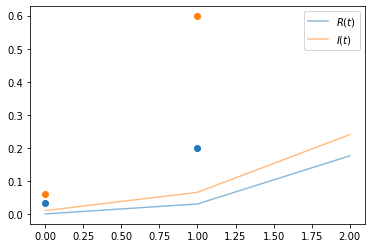

In [13]:
# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[0:len(yobs)],yobs, marker='o', linestyle='none')
plt.plot(times[0:len(y)], y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times[0:len(y)], y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 286 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.30,0.45,0.02,1.01,0.05,0.03,87.0,87.0,37.0,43.0,1.05
sigma[1],0.99,0.72,0.29,2.05,0.06,0.04,158.0,158.0,180.0,224.0,1.01
R0,3.18,0.31,2.64,3.91,0.04,0.03,72.0,72.0,118.0,60.0,1.05


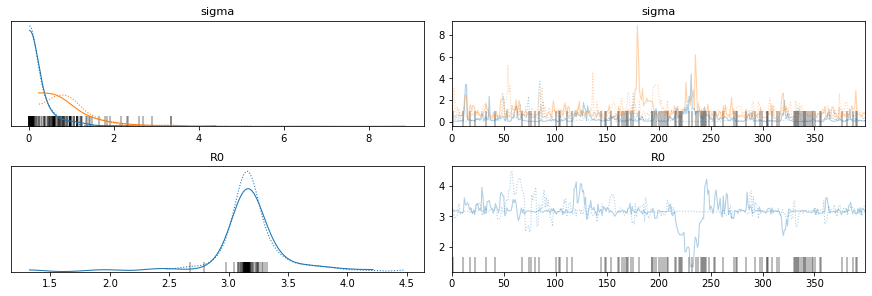

In [14]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data,1*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 2, #r(ecovered) and i(nfected) are states
    n_theta = 1, # beta=R0 only parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=2 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=1)( 'R0', 3, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0], theta=[R0] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(400,tune=1000, step=step, random_seed=44)

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f784a694320>,
      dtype=object)

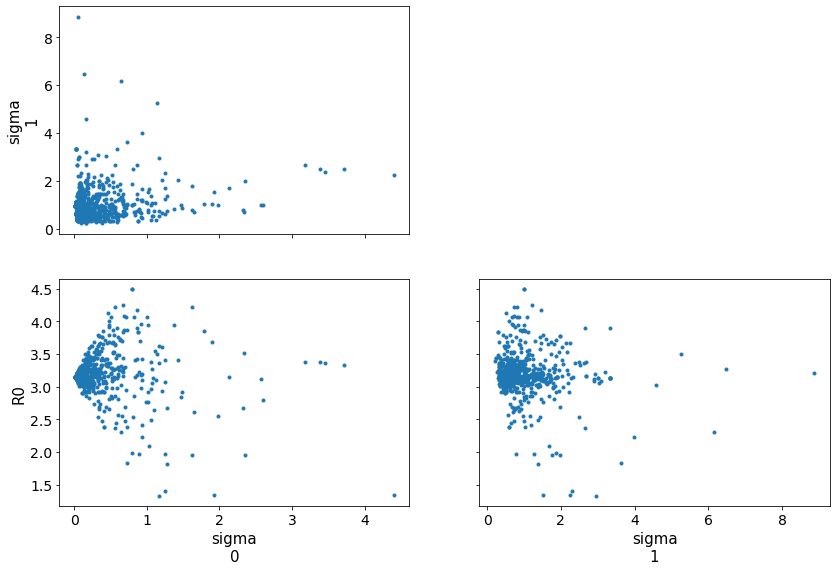

In [15]:
pm.pairplot(trace)

#### For R0 = 1.1 :

In [0]:
f = 3.0 # time factor, defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)
times = np.arange(0,5*f,timestep_data)
#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 1.1

In [0]:
def SIR(y, t, p):
    #ds = -p[0]*y[0]*y[1] # we do not need susceptibles as S=1-I-R is determ dependent on i and r
    #dr = y[1] #component 0 = recovered, gamma=1 (will be returned directly)
    di = p[0]*(1-y[0]-y[1])*y[1] - y[1] #component 1 = infected, gamma=1 (SIR in one line)
    return [y[1], di] # return r(ecov) and i(nfect)

In [0]:
# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0], args=([beta],), rtol=1e-8) # r0 recovered, i0 infected  at t0
result = np.where(y == np.amax(y[:,1]))[0]
y = y[0:result[0], :]
# Observational model for muliplicative noise
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.60]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)

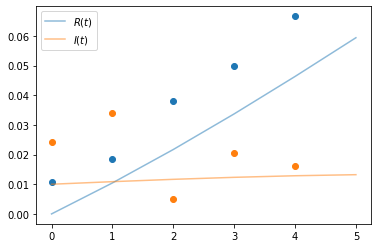

In [20]:
# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[0:len(yobs)],yobs, marker='o', linestyle='none')
plt.plot(times[0:len(y)], y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times[0:len(y)], y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 133 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.15,0.09,0.05,0.30,0.00,0.00,309.0,309.0,309.0,353.0,1.00
sigma[1],0.89,0.38,0.44,1.46,0.02,0.02,315.0,301.0,316.0,287.0,1.01
R0,1.14,0.04,1.06,1.22,0.00,0.00,310.0,310.0,310.0,195.0,1.01


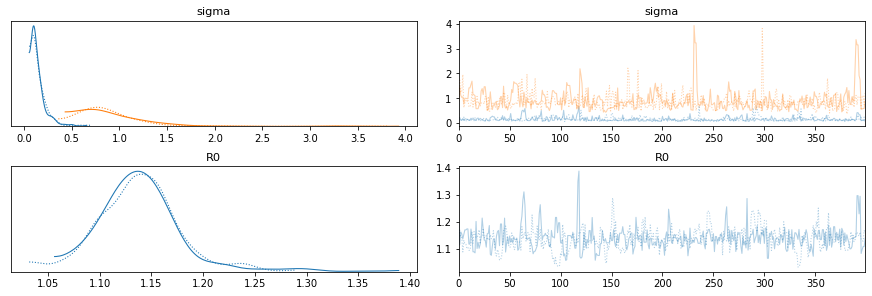

In [21]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data,2*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 2, #r(ecovered) and i(nfected) are states
    n_theta = 1, # beta=R0 only parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=2 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=1)( 'R0', 1, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0], theta=[R0] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(400, step=step, random_seed=44,cores=2)

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78233aac18>,
      dtype=object)

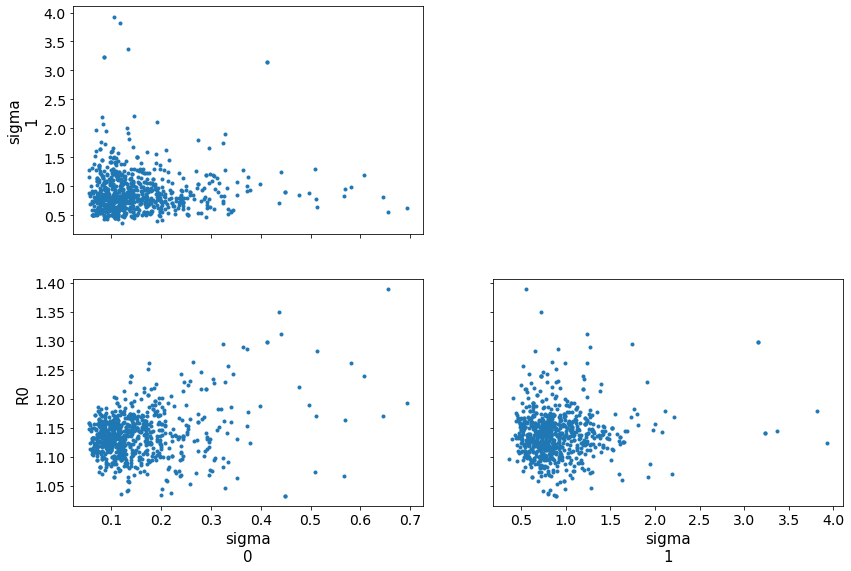

In [22]:
pm.pairplot(trace)

### Conclusion

 The model is faster for the lower values of $R0$. It took 131 seconds to run it for 1.1 in comparison to 291 seconds for , The model is more accurate for $R0$ 1.1 and the inference work better for $R0$ equivalent to 1.1 as well as it has lower deviations and for $R0 = 3$ there are are lot of divergence as well 

## Task b)

### Infer R0 given I and S, Before the peak

In [0]:
# Define initial conditions of SIR model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
s0 = 1-i0-r0
N=1
#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 3
gamma=1

In [0]:
f = 3.0 # time factor, defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)
times = np.arange(0,5*f,timestep_data)

In [0]:
def SIR(y, t, beta):
    dSdt = -beta[0] * y[0] * y[1] /1 
    dIdt = beta[0] *y[0]* y[1] / 1 - 1 * y[1]
    dRdt = 1* y[1]
    return dSdt, dIdt

In [0]:
# Create SIR curves
y = odeint(SIR, t=times, y0=[s0, i0], args=([beta],),  rtol=1e-8) # r0 recovered, i0 infected  at t0
result = np.where(y == np.amax(y[:,1]))[0]
y = y[0:result[0], :]
# Observational model for muliplicative noise
yobs = np.random.lognormal(mean=np.log(y[0::]), sigma=[0.2, 0.6]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)

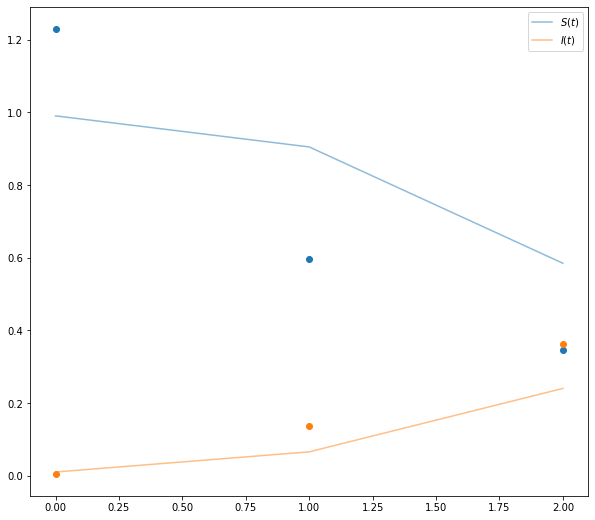

In [27]:
# Plot the deterministic curves, and those with multiplicative noise
plt.figure(figsize=(10,9))
plt.plot(times[0:len(yobs)],yobs, marker='o', linestyle='none')
plt.plot(times[0:len(y)], y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times[0:len(y)], y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')

plt.legend()
plt.show()

In [0]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(0,1*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 2, #r(ecovered) and i(nfected) are states
    n_theta = 1, # beta=R0 only parameter
    t0=0
)

Only 400 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 319 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.42,0.27,0.13,0.86,0.02,0.01,304.0,304.0,346.0,387.0,1.00
sigma[1],0.56,0.34,0.18,1.21,0.02,0.02,200.0,200.0,223.0,351.0,1.01
R0,3.69,0.33,3.02,4.27,0.02,0.01,358.0,358.0,386.0,245.0,1.01


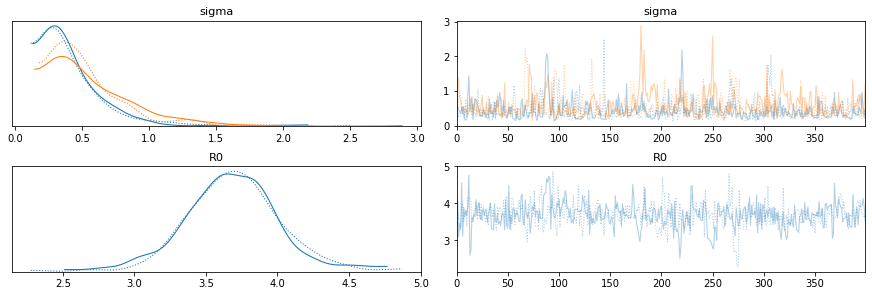

In [29]:
# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=2 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=1)( 'R0', 2.5, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[s0, i0], theta=[R0] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(400, step=step, random_seed=44,cores=2)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    #data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

### Conclusion

We can see that our true value was estimated poorly and the standard deviation is relatively high.
The $R0$ value in our case is predicted between 3.1 to 4.3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f782012ca58>,
      dtype=object)

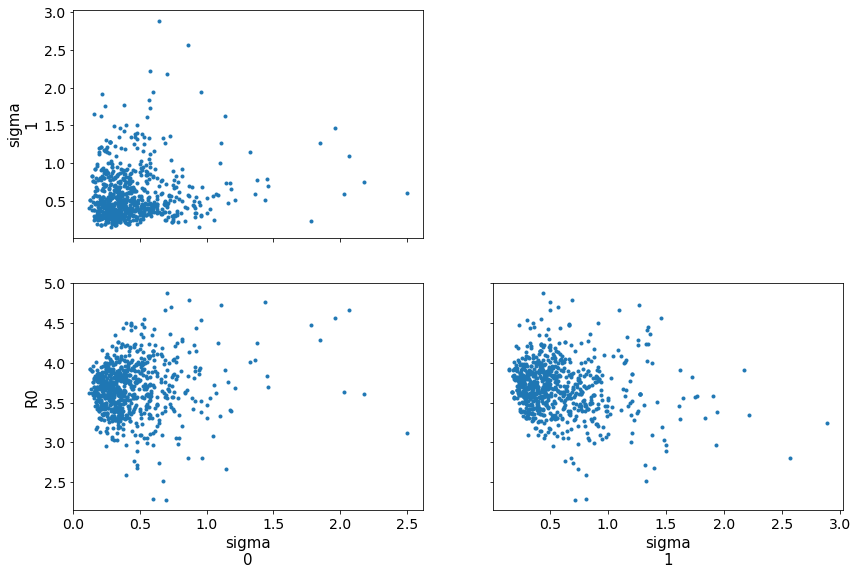

In [30]:
pm.pairplot(trace)

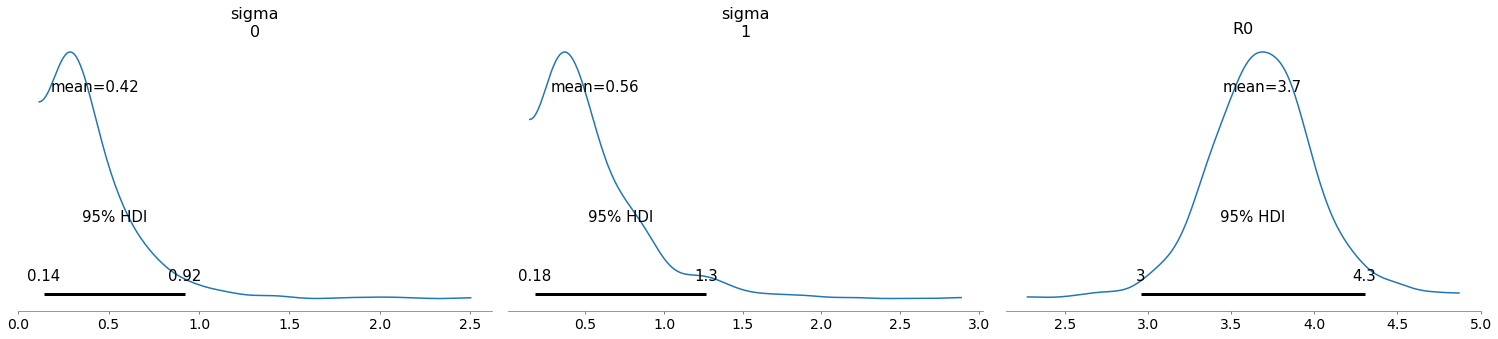

In [33]:
data = az.from_pymc3(trace=trace, posterior_predictive = posterior_predictive)
az.plot_posterior(data,round_to=2, credible_interval=0.95);